# RA-DEC Measurement Generation
This notebook does following:
* TLE of a satellite is acquired.
* SGP4 propagator is set.
* RA-DEC generator created.
* Generated RA-DEC .......

In [1]:
# Satellite Dictionary
sat_list = {    
    'envisat': {
        'norad_id': 27386,                    # For Space-Track TLE queries
        'cospar_id': '0200901',               # For laser ranging data queries
        'sic_id': '6179',                     # For writing in CPF files
        'mass': 8000.0,                       # kg; TODO: compute proper value
        'cross_section': 100.0,               # m2; TODO: compute proper value
        'cd': 2.0,                            # Drag coefficient; TODO: compute proper value
        'cr': 1.0                             # Radiation coefficient; TODO: compute proper value
    },
    'starlink45185': {
        'norad_id': 45185,
        'cospar_id': '2001208',
        'sic_id': '5986',                     # TODO: correct it
        'mass': 260.0,                        # kg
        'cross_section': 5.0,                 # m2
        'cd': 1.0,                            # TODO: compute proper value
        'cr': 1.0                             # TODO: compute proper value
    }
}

sc_name = 'starlink45185'                     # Change the name to select a different satellite in the dict

## Setting Up  Orekit Models
Initializing Orekit and JVM

In [2]:
import orekit
orekit.initVM()

import warnings                      # To surpress warnings
warnings.filterwarnings('ignore')

# Modified from https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/python_files/pyhelpers.py
from java.io import File
from org.orekit.data import DataProvidersManager, DirectoryCrawler, DataContext
from orekit import JArray, JArray_double

orekit_data_dir = 'orekit-data'
#DM = DataProvidersManager.getInstance()                 
DM = DataContext.getDefault().getDataProvidersManager()
datafile = File(orekit_data_dir)
if not datafile.exists():
    print('Directory :', datafile.absolutePath, ' not found')

crawler = DirectoryCrawler(datafile)
DM.clearProviders()
DM.addProvider(crawler)

# Orekit packages
from org.orekit.propagation.analytical.tle import TLE, SGP4
from org.orekit.propagation import SpacecraftState
from org.orekit.utils import Constants, IERSConventions, PVCoordinates, AbsolutePVCoordinates
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.models.earth import ReferenceEllipsoid
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.attitudes import NadirPointing
from org.orekit.orbits import CartesianOrbit, Orbit
from org.orekit.estimation.measurements import ObservableSatellite, GroundStation, AngularRaDec,Range
from orekit.pyhelpers import absolutedate_to_datetime, JArray

# Hipparchus packages
from org.hipparchus.linear import MatrixUtils, Array2DRowRealMatrix
from org.hipparchus.geometry.euclidean.threed import Vector3D
from java.util import ArrayList, Arrays

# Misc packages
import pandas as  pd
import matplotlib.pyplot as plt
from math import radians, pi, degrees, sin, cos, sqrt, acos, atan2
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np

Some functions are defined below.

In [3]:
def orekitPV2dataframe(PV, currentDateTime):
    import pandas as pd
    pos = PV.getPosition()
    vel = PV.getVelocity()
    data = {'DateTimeUTC': currentDateTime,
            'px': pos.getX(), 'py': pos.getY(), 'pz': pos.getZ(),
            'vx': vel.getX(), 'vy': vel.getY(), 'vz': vel.getZ()}
    return pd.DataFrame(data, index=[currentDateTime])


def orekitRADEC2dataframe(RADEC, currentDateTime):
    import pandas as pd
    ra   = RADEC.getObservedValue()[0]
    ra   = degrees(ra)
    dec  = RADEC.getObservedValue()[1]
    dec  = degrees(dec)
    data = {'DateTimeUTC': currentDateTime,
            'ra': ra, 'dec': dec}
    return pd.DataFrame(data, index=[currentDateTime])


def orekitRADEC2dataframe_v2(ra, dec, currentDateTime):
    import pandas as pd
    data = {'DateTimeUTC': currentDateTime,
            'ra': ra, 'dec': dec}
    return pd.DataFrame(data, index=[currentDateTime])


def orekitRANGE2dataframe(RANGE, currentDateTime):
    import pandas as pd
    Range = RANGE.getObservedValue()[0]
    data  = {'DateTimeUTC': currentDateTime,
             'range': Range}
    return pd.DataFrame(data, index=[currentDateTime])


def cartesian_to_radec(x, y, z):
    import math 
    # Convert to spherical coordinates (Ra, Dec)
    ra = math.atan2(y, x)  # Right Ascension
    dec = math.atan2(z, math.sqrt(x**2 + y**2))  # Declination
    
    # Convert RA and Dec to degrees
    ra = math.degrees(ra)
    if ra < 0:
        ra += 360.0
    dec = math.degrees(dec)
    
    return ra, dec

## API Credentials
The following sets up accounts for SpaceTrack (for orbit data).
* A SpaceTrack account is required, it can be created for free at: https://www.space-track.org/auth/createAccount

In [4]:
# Space-Track
import getpass

identity_st = input('Enter SpaceTrack Username')
password_st = input('Enter SpaceTrack Password')

# identity_st = input('Enter SpaceTrack username ')
# password_st = getpass.getpass(prompt='Enter SpaceTrack password for account {}'.format(identity_st))
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
st = SpaceTrackClient(identity=identity_st, password=password_st)

The orbit determination needs a first guess. For this, we use Two-Line Elements retrieved from Spacetrack. Retrieving the latest TLE prior to the beginning of the orbit determination. It is important to have a "fresh" TLE, because the newer the TLE, the better the orbit estimation.

In [5]:
odDate = datetime(2022, 7, 3, 19, 0, 0)     # Beginning of the OD

rawTle = st.tle(norad_cat_id=sat_list[sc_name]['norad_id'], epoch='<{}'.format(odDate), orderby='epoch desc', limit=1, format='tle')
tleLine1 = rawTle.split('\n')[0]
tleLine2 = rawTle.split('\n')[1]
print(tleLine1)
print(tleLine2)

1 45185U 20012H   22184.78125401  .00001809  00000-0  14031-3 0  9993
2 45185  53.0560 324.1501 0001383  79.2190 280.8955 15.06406081132074


Setting up Orekit frames and models

In [6]:
TOD  = FramesFactory.getTOD(IERSConventions.IERS_2010, False) # Taking tidal effects into account when interpolating EOP parameters
GCRF = FramesFactory.getGCRF()
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
TEME = FramesFactory.getTEME()
ECI  = GCRF
ECEF = ITRF

R_earth = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
Mu_earth = Constants.WGS84_EARTH_MU
F_earth = Constants.WGS84_EARTH_FLATTENING
earth = OneAxisEllipsoid(R_earth, F_earth, ITRF)          # Define earth body for later use.

wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(ECEF)

moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()

nadirPointing = NadirPointing(ECI, wgs84Ellipsoid)         # Set the attitude to nadir pointing

UTC = TimeScalesFactory.getUTC()
mjd_utc_epoch = AbsoluteDate(1858, 11, 17, 0, 0, 0.0, UTC)

In [7]:
# Set up the propagator either from the initial TLE
orekitTle       = TLE(tleLine1, tleLine2)                      

# Create the SGP4 propagator
propagator      = SGP4(orekitTle, nadirPointing, sat_list[sc_name]['mass'])   

# Get TLE initial state and the date
tleInitialState = propagator.getInitialState()
tleEpoch        = tleInitialState.getDate()                                   

dt              = 60.0
date_start      = tleEpoch
date_end        = date_start.shiftedBy(86400.0)

print('\033[1m'+'TLE Date Start: '+'\033[0m', date_start)
print('\033[1m'+'TLE Date End: '+'\033[0m', date_end)

TLE Date Start:  2022-07-03T18:45:00.346464Z
TLE Date End:  2022-07-04T18:45:00.346464Z


In [8]:
# Define the ground station in geodetic coordinates.
latitude = radians(32.92)
longitude = radians(-105.528)
altitude = 2225.0 

# Frame of the ground station is given as Topocentric Frame.
station_coord = GeodeticPoint(latitude, longitude, altitude)
station_frame = TopocentricFrame(earth, station_coord, "Vallado")

# Create the ground station.
ground_station = GroundStation(station_frame)

## Range and Ra-Dec Measurement Generation

In [9]:
from org.orekit.estimation.measurements.generation import AngularRaDecBuilder, RangeBuilder, Generator, ContinuousScheduler
from org.hipparchus.random import GaussianRandomGenerator, MersenneTwister, UniformRandomGenerator, CorrelatedRandomVectorGenerator
from org.orekit.time import FixedStepSelector

sigma           = 1e-3
rangeError      = sigma 
raDecError      = [sigma, sigma]                                          
raDecBaseWeight = [1.0, 1.0]
rangeBaseWeight = 1.0

covariance = MatrixUtils.createRealDiagonalMatrix([sigma**2,   # Covariance matrix
                                                   sigma**2, 
                                                   sigma**2, 
                                                   sigma**2, 
                                                   sigma**2, 
                                                   sigma**2])

# Random correlated vector
random_vector = CorrelatedRandomVectorGenerator(covariance, 1.0e-10, 
                                                UniformRandomGenerator(MersenneTwister()))

# Make the generator
obs_sat         = ObservableSatellite(0)
generator_range = Generator()
generator_radec = Generator()     

generator_range.addPropagator(propagator)   
generator_radec.addPropagator(propagator)

rangeBuilder = RangeBuilder(random_vector, ground_station, True, rangeError, rangeBaseWeight, obs_sat)   
radecBuilder = AngularRaDecBuilder(random_vector, ground_station, station_frame, raDecError, raDecBaseWeight, obs_sat)      

generator_range.addScheduler(ContinuousScheduler(rangeBuilder, FixedStepSelector(dt, TimeScalesFactory.getUTC())))           
generator_radec.addScheduler(ContinuousScheduler(radecBuilder, FixedStepSelector(dt, TimeScalesFactory.getUTC())))

# Measurement data is generated
range_measurement_data = generator_range.generate(date_start, date_end)   
radec_measurement_data = generator_radec.generate(date_start, date_end)   

In [10]:
RANGE_generated_df     = pd.DataFrame()
RADEC_generated_eci_df = pd.DataFrame()

for measurements in range_measurement_data:
    castedRangeMeasurements = Range.cast_(measurements)      # Casting measurements into Range
    
    RANGE_generated_eci_df = pd.concat([RANGE_generated_df, orekitRANGE2dataframe(castedRangeMeasurements, castedRangeMeasurements.getDate())])
    
    for measurements in radec_measurement_data:
        castedRadecMeasurements = AngularRaDec.cast_(measurements)      # Casting measurements into Ra-Dec
    
        gen_R  = castedRangeMeasurements.getObservedValue()[0]
        gen_x  = gen_R*cos(radians(castedRadecMeasurements.getObservedValue()[0]))*cos(radians(castedRadecMeasurements.getObservedValue()[1]))
        gen_y  = gen_R*sin(radians(castedRadecMeasurements.getObservedValue()[0]))*cos(radians(castedRadecMeasurements.getObservedValue()[1]))
        gen_z  = gen_R*sin(radians(castedRadecMeasurements.getObservedValue()[1]))
    
        gen_PV = PVCoordinates(Vector3D([gen_x, gen_y, gen_z]))

        topo2ECI   = station_frame.getTransformTo(ECI, castedRadecMeasurements.getDate())
        gen_PV_eci = topo2ECI.transformPVCoordinates(gen_PV)
        
        ra, dec = cartesian_to_radec(gen_PV_eci.getPosition().getX(), gen_PV_eci.getPosition().getY(), gen_PV_eci.getPosition().getZ())

        RADEC_generated_eci_df = pd.concat([RADEC_generated_eci_df, orekitRADEC2dataframe_v2(ra, dec, castedRadecMeasurements.getDate())])
        
        break

RADEC_generated_eci_df.reset_index(drop=True, inplace=True)
print('\033[1m'+'RADEC_generated_eci_df '+'\033[0m')
display(RADEC_generated_eci_df)

RADEC_generated_eci_df 


DateTimeUTC          ra        dec
0     2022-07-03T18:45:59.99999999999798Z  164.593482  16.836591
1     2022-07-03T18:45:59.99999999999798Z  164.192791  17.045499
2     2022-07-03T18:45:59.99999999999798Z  163.756984  17.271296
3     2022-07-03T18:45:59.99999999999798Z  163.283756  17.514794
4     2022-07-03T18:45:59.99999999999798Z  162.770540  17.776868
...                                   ...         ...        ...
1435  2022-07-03T18:45:59.99999999999798Z  164.124092  17.081191
1436  2022-07-03T18:45:59.99999999999798Z  163.678581  17.311760
1437  2022-07-03T18:45:59.99999999999798Z  163.194843  17.560347
1438  2022-07-03T18:45:59.99999999999798Z  162.670217  17.827852
1439  2022-07-03T18:45:59.99999999999798Z  162.101737  18.115238

[1440 rows x 3 columns]

## Ra-Dec Measurement Generation 

In [11]:
RADEC_tle_eci_df = pd.DataFrame()


date_current = RADEC_generated_eci_df['DateTimeUTC'][0]
propagator.propagate(date_current)

while date_current.compareTo(date_end) <= 0:
    datetime_current = absolutedate_to_datetime(date_current)    
    
    PV_tle_eci = propagator.getPVCoordinates(date_current, ECI)
    pos = PV_tle_eci.getPosition()
    
    ra, dec = cartesian_to_radec(pos.getX(), pos.getY(), pos.getZ())
    ra      = radians(ra)
    dec     = radians(dec)
    radec   = AngularRaDec(ground_station, station_frame, date_current, [ra, dec], 
                           raDecError, raDecBaseWeight, obs_sat)
    
    RADEC_tle_eci_df = pd.concat([RADEC_tle_eci_df, orekitRADEC2dataframe(radec, datetime_current)])
    
       
    date_current = date_current.shiftedBy(dt)

RADEC_tle_eci_df.reset_index(drop=True, inplace=True)

print('\033[1m'+'RADEC_tle_eci_df '+'\033[0m')
display(RADEC_tle_eci_df) 

RADEC_tle_eci_df 


DateTimeUTC          ra        dec
0    2022-07-03 18:45:59.999999  326.117607   2.891268
1    2022-07-03 18:46:59.999999  328.398959   5.895065
2    2022-07-03 18:47:59.999999  330.705445   8.889829
3    2022-07-03 18:48:59.999999  333.050226  11.870504
4    2022-07-03 18:49:59.999999  335.447064  14.831730
...                         ...         ...        ...
1435 2022-07-04 18:40:59.999999  326.050893   8.654218
1436 2022-07-04 18:41:59.999999  328.392546  11.635852
1437 2022-07-04 18:42:59.999999  330.785146  14.598468
1438 2022-07-04 18:43:59.999999  333.243193  17.536316
1439 2022-07-04 18:44:59.999999  335.782193  20.443106

[1440 rows x 3 columns]

In [12]:

ra_residuals  = RADEC_tle_eci_df['ra'].values - RADEC_generated_eci_df['ra']
dec_residuals = RADEC_tle_eci_df['dec'].values - RADEC_generated_eci_df['dec']


radec_residuals_df = pd.DataFrame({'DateTime UTC': RADEC_tle_eci_df['DateTimeUTC'],
                                   'ra_residual': ra_residuals, 
                                   'dec_residual': dec_residuals})

display(radec_residuals_df)

DateTime UTC  ra_residual  dec_residual
0    2022-07-03 18:45:59.999999   161.524125    -13.945323
1    2022-07-03 18:46:59.999999   164.206168    -11.150434
2    2022-07-03 18:47:59.999999   166.948461     -8.381467
3    2022-07-03 18:48:59.999999   169.766470     -5.644290
4    2022-07-03 18:49:59.999999   172.676524     -2.945138
...                         ...          ...           ...
1435 2022-07-04 18:40:59.999999   161.926801     -8.426973
1436 2022-07-04 18:41:59.999999   164.713965     -5.675908
1437 2022-07-04 18:42:59.999999   167.590302     -2.961879
1438 2022-07-04 18:43:59.999999   170.572976     -0.291536
1439 2022-07-04 18:44:59.999999   173.680456      2.327868

[1440 rows x 3 columns]

## Plotting Residuals Between TLE and Generated Measurements

In [13]:
import plotly.io as pio
import plotly.graph_objs as go
pio.renderers.default = 'jupyterlab+notebook+png'     # Uncomment for interactive plots
#pio.renderers.default = 'png'

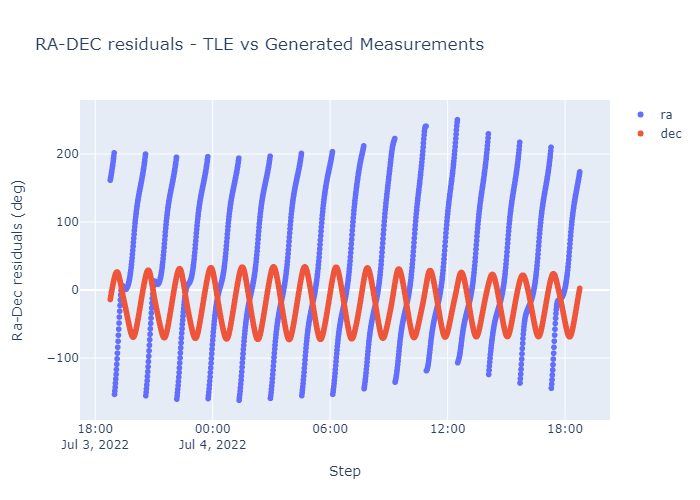

In [14]:
trace1 = go.Scattergl(x=radec_residuals_df['DateTime UTC'], 
                      y=radec_residuals_df['ra_residual'],
                      mode='markers', name='ra')

trace2 = go.Scattergl(x=radec_residuals_df['DateTime UTC'], 
                      y=radec_residuals_df['dec_residual'],
                      mode='markers', name='dec')

data = [trace1, trace2]

layout = go.Layout(title = 'RA-DEC residuals - TLE vs Generated Measurements',
                   xaxis = dict(title = 'Step'),
                   yaxis = dict(title = 'Ra-Dec residuals (deg)'))
 
fig = dict(data=data, layout=layout)

pio.show(fig)